In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import wrf

In [2]:
unpHdl=Dataset('wrfinput_d01')
pt1Hdl=Dataset('wrfinput_d01_perturbed_old')
pt2Hdl=Dataset('wrfinput_d01_perturbed_new')

In [3]:
q0=np.asarray(unpHdl.variables['QVAPOR']).squeeze()
q1=np.asarray(pt1Hdl.variables['QVAPOR']).squeeze()
q2=np.asarray(pt2Hdl.variables['QVAPOR']).squeeze()

In [20]:
p0 = np.asarray(wrf.getvar(unpHdl,'p')).squeeze() * 0.01
t0 = 300. + np.asarray(unpHdl.variables['T']).squeeze() - 273.15
es_exp = np.divide(7.5*t0,237.3+t0)
init_es = 6.11*np.power(10.,es_exp)
init_ws = 0.62197*np.divide(init_es,p0-init_es)
rh0 = np.divide(q0,init_ws)

In [21]:
p1 = np.asarray(wrf.getvar(pt1Hdl,'p')).squeeze() * 0.01
t1 = 300. + np.asarray(pt1Hdl.variables['T']).squeeze() - 273.15
es_exp = np.divide(7.5*t1,237.3+t1)
init_es = 6.11*np.power(10.,es_exp)
init_ws = 0.62197*np.divide(init_es,p1-init_es)
rh1 = np.divide(q1,init_ws)

In [22]:
p2 = np.asarray(wrf.getvar(pt2Hdl,'p')).squeeze() * 0.01
t2 = 300. + np.asarray(pt2Hdl.variables['T']).squeeze() - 273.15
es_exp = np.divide(7.5*t2,237.3+t2)
init_es = 6.11*np.power(10.,es_exp)
init_ws = 0.62197*np.divide(init_es,p2-init_es)
rh2 = np.divide(q2,init_ws)

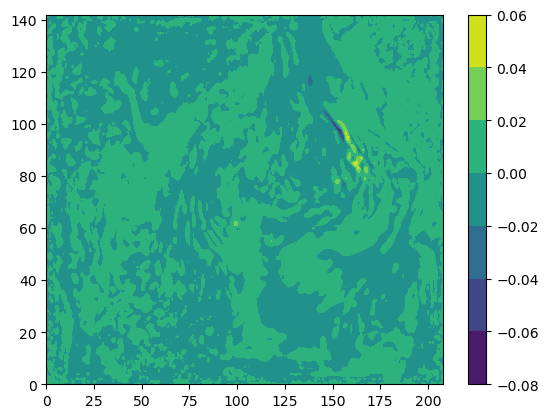

In [25]:
k=3

plt.contourf(100.*rh2[k,:,:].squeeze()-100.*rh0[k,:,:].squeeze())
plt.colorbar()
plt.show()

In [26]:
# get_wrf_slp: given the netCDF4 Dataset() handle for a WRF file, produces the sea-level pressure
#
# INPUTS:
#
# wrfHdl: WRF file netCDF4.Dataset() handle
#
# OUTPUTS:
#
# slp: sea-level pressure in (ny,nx) dimension (hPa)
#
# DEPENDENCIES:
#
# numpy
# netCDF4.Dataset()
# wrf(-python)
def get_wrf_slp(wrfHdl):
    import numpy as np
    from netCDF4 import Dataset
    import wrf
    # Define base-state pot. temperature as 300 K
    # NOTE: This is different from the 'T00' variable in the WRF file, which is specific
    #       to an internal parameter used for a hypothetical WRF profile. See dev notes
    #       under 'derived variables for wrf-python'/'Computing temperature correctly'
    #       for details
    baseTp = 300.  # (K)
    # Define other constants
    R = 287.053  # dry gas constant (J/K*kg)
    cp = 1005.  # heat capacity of air at constant pressure (J/K*kg)
    kappa = R/cp  # (dimensionless)
    # Draw necessary fields to produce slp:
    #  Z: geopotential height (m)
    #  dynaTp: 'dynamic', or perturbation pot. temperature added to baseTp to derive full Tp (K)
    #  P: total pressure (baseP + dynaP) (Pa)
    #  baseP: base-state pressure - this is directly from 'P00' stored in WRF file (Pa)
    #  qVap: water vapor mixing ratio (kg/kg)
    Z = np.asarray(wrf.getvar(wrfHdl,'z')).squeeze()
    dynaTp = np.asarray(wrfHdl.variables['T']).squeeze()
    P = np.asarray(wrf.getvar(wrfHdl,'p')).squeeze()
    baseP = np.asarray(wrfHdl.variables['P00']).squeeze()
    qVap = np.asarray(wrfHdl.variables['QVAPOR']).squeeze()
    # Compute Tp (K)
    Tp = dynaTp + baseTp
    # Compute temperature T (K)
    T = Tp * np.power(P / baseP, kappa)
    # Derive slp from input (Z,T,P,qVap)
    slp = wrf.slp(Z, T, P, qVap)  # hPa
    # Return slp
    return slp


# get_wrf_rh: given the netCDF4 Dataset() handle for a WRF file, produces the relative humidity
#
# INPUTS:
#
# wrfHdl: WRF file netCDF4.Dataset() handle
#
# OUTPUTS:
#
# rh: relative humidity in (nz,ny,nx) dimension (%)
#
# DEPENDENCIES:
#
# numpy
# netCDF4.Dataset()
# wrf(-python)
def get_wrf_rh(wrfHdl):
    import numpy as np
    from netCDF4 import Dataset
    import wrf
    # Define base-state pot. temperature as 300 K
    # NOTE: This is different from the 'T00' variable in the WRF file, which is specific
    #       to an internal parameter used for a hypothetical WRF profile. See dev notes
    #       under 'derived variables for wrf-python'/'Computing temperature correctly'
    #       for details
    baseTp = 300.  # (K)
    # Define other constants
    R = 287.053  # dry gas constant (J/K*kg)
    cp = 1005.  # heat capacity of air at constant pressure (J/K*kg)
    kappa = R/cp  # (dimensionless)
    # Draw necessary fields to produce slp:
    #  dynaTp: 'dynamic', or perturbation pot. temperature added to baseTp to derive full Tp (K)
    #  P: total pressure (baseP + dynaP) (Pa)
    #  baseP: base-state pressure - this is directly from 'P00' stored in WRF file (Pa)
    #  qVap: water vapor mixing ratio (kg/kg)
    dynaTp = np.asarray(wrfHdl.variables['T']).squeeze()
    P = np.asarray(wrf.getvar(wrfHdl,'p')).squeeze()
    baseP = np.asarray(wrfHdl.variables['P00']).squeeze()
    qVap = np.asarray(wrfHdl.variables['QVAPOR']).squeeze()
    # Compute Tp (K)
    Tp = dynaTp + baseTp
    # Compute temperature T (K)
    T = Tp * np.power(P / baseP, kappa)
    # Derive rh from input (qVap,P,T)
    rh = wrf.rh(qVap, P, T)  # (%)
    # Return rh
    return rh

In [27]:
rh0=get_wrf_rh(unpHdl)
rh1=get_wrf_rh(pt1Hdl)
rh2=get_wrf_rh(pt2Hdl)

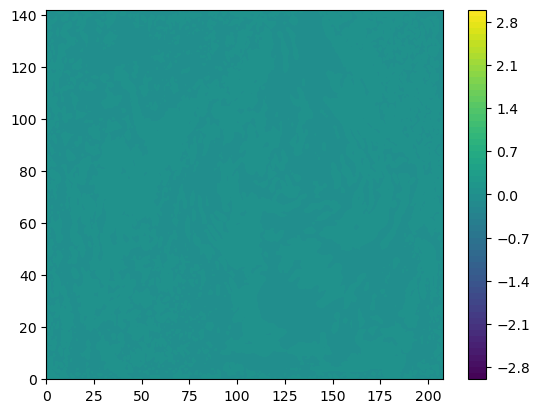

In [68]:
k=3

plt.contourf(rh2[k,:,:].squeeze()-rh0[k,:,:].squeeze(),np.arange(-3.,3.1,0.1))
plt.colorbar()
plt.show()

In [53]:
wrfinput_hdl = unpHdl
#
# Extract additional (or unit-specific) fields from wrfinput for 
# computing the compensating moisture term
#
init_p = np.asarray(wrf.getvar(
                               wrfinput_hdl ,
                               'pres'       ,
                               units='hPa'
                              )
                   ).squeeze() #. full model pressure (hPa) [lev,lat,lon]
init_t = np.asarray(wrfinput_hdl.variables['T']).squeeze() + 300. - 273.15  # full model temperature (deg C) [lev,lat,lon]
q0 = np.asarray(wrfinput_hdl.variables['QVAPOR']).squeeze() #.................................. unperturbed water vapor mixing ratio (kg/kg) [lev,lat,lon]
#
# Compute saturation vapor pressure, according to the equation provided here:
#
# https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf
#
es_exp = np.divide(7.5*init_t,237.3+init_t) #............................ exponent of saturation vapor pressure
init_es = 6.11*np.power(10.,es_exp) #.................................... full model saturation vapor pressure (hPa) [lev,lat,lon]
#
# Compute saturation vapor pressure after perturbation
#
tp = np.asarray(pt1Hdl.variables['T']).squeeze() - np.asarray(unpHdl.variables['T']).squeeze()
es_exp = np.divide(7.5*(init_t+tp),237.3+(init_t+tp)) #...................... exponent of saturation vapor pressure
init_es_p = 6.11*np.power(10.,es_exp) #.................................. full model (perturbed) saturation vapor pressure (hPa) [lev,lat,lon]
#
# Compute saturation mixing ratio, according to the equation provided here:
#
# https://www.weather.gov/media/epz/wxcalc/mixingRatio.pdf
#
# We are immediately computing in (kg/kg) by dividing the coefficient by
# 1000.0 here, i.e. 621.97 --> 0.62197
#
init_ws = 0.62197*np.divide(init_es,init_p-init_es) #.................... full model saturation mixing ratio (kg/kg) [lev,lat,lon]
#
# Compute saturation mixing ratio after perturbation
#
init_ws_p = 0.62197*np.divide(init_es_p,init_p-init_es_p) #.............. full model (perturbed) saturation mixing ratio (kg/kg) [lev,lat,lon]
#
# Compute the necessary mixing ratio to keep relative humidity constant:
#
# (q1/ws1) = (q2/ws2) --> q2 = q1(ws2/ws1)
#
q_p = q0 * np.divide(init_ws_p,init_ws) #................................ full model (perturbed) mixing ratio to maintain unperturbed rh (kg/kg) [lev,lat,lon]
#
# Compute initial mixing ratio perturbation to keep relative humidity
# constant
#
qp = q_p - q0 #.......................................................... NON-optimal mixing ratio perturbation to keep rh constant [lev,lat,lon]

In [54]:
p1 = np.asarray(wrf.getvar(pt1Hdl,'p')).squeeze() * 0.01
t1 = 300. + np.asarray(pt1Hdl.variables['T']).squeeze() - 273.15
es_exp = np.divide(7.5*t1,237.3+t1)
init_es = 6.11*np.power(10.,es_exp)
init_ws = 0.62197*np.divide(init_es,p1-init_es)
rh3 = np.divide(q_p,init_ws)

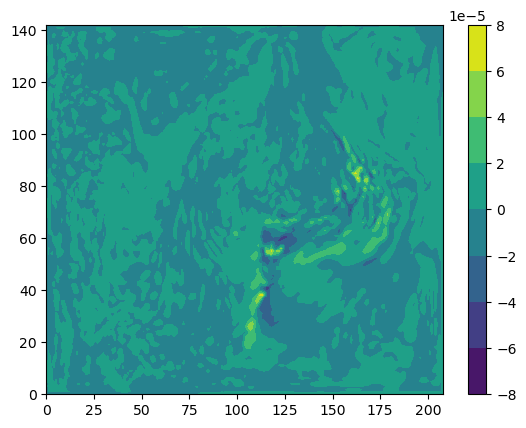

In [64]:
k=3

plt.contourf(q_p[0,k,:,:].squeeze()-q0[0,k,:,:].squeeze())
plt.colorbar()
plt.show()

In [63]:
np.shape(q0)

(1, 40, 143, 209)

In [56]:
#
# Extract additional (or unit-specific) fields from wrfinput for 
# computing the compensating moisture term
#
init_p = np.asarray(wrf.getvar(
                               unpHdl ,
                               'pres'       ,
                               units='hPa'
                              )
                   ).squeeze() #. full model pressure (hPa) [lev,lat,lon]
init_t = np.asarray(unpHdl.variables['T']).squeeze() + 300. - 273.15 # full model temperature (deg C) [lev,lat,lon]
q0 = unpHdl.variables['QVAPOR'] #.................................. unperturbed water vapor mixing ratio (kg/kg) [lev,lat,lon]
#
# Compute saturation vapor pressure, according to the equation provided here:
#
# https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf
#
es_exp = np.divide(7.5*init_t,237.3+init_t) #............................ exponent of saturation vapor pressure
init_es = 6.11*np.power(10.,es_exp) #.................................... full model saturation vapor pressure (hPa) [lev,lat,lon]

tp = np.asarray(pt2Hdl.variables['T']).squeeze() - np.asarray(unpHdl.variables['T']).squeeze()


#
# Compute saturation vapor pressure after perturbation
#
es_exp = np.divide(7.5*(init_t+tp),237.3+(init_t+tp)) #.................. exponent of saturation vapor pressure
init_es_p = 6.11*np.power(10.,es_exp) #.................................. full model (perturbed) saturation vapor pressure (hPa) [lev,lat,lon]
#
# Compute saturation mixing ratio, according to the equation provided here:
#
# https://www.weather.gov/media/epz/wxcalc/mixingRatio.pdf
#
# We are immediately computing in (kg/kg) by dividing the coefficient by
# 1000.0 here, i.e. 621.97 --> 0.62197
#
init_ws = 0.62197*np.divide(init_es,init_p-init_es) #.................... full model saturation mixing ratio (kg/kg) [lev,lat,lon]
#
# Compute saturation mixing ratio after perturbation
#
init_ws_p = 0.62197*np.divide(init_es_p,init_p-init_es_p) #.............. full model (perturbed) saturation mixing ratio (kg/kg) [lev,lat,lon]
#
# Compute the necessary mixing ratio to keep relative humidity constant:
#
# (q1/ws1) = (q2/ws2) --> q2 = q1(ws2/ws1)
#
q_p = np.multiply(q0,np.divide(init_ws_p,init_ws)) #..................... full model (perturbed) mixing ratio to maintain unperturbed rh (kg/kg) [lev,lat,lon]
#

In [57]:
rh3=wrf.rh(q_p.squeeze(),p2*100.,t2+273.15)

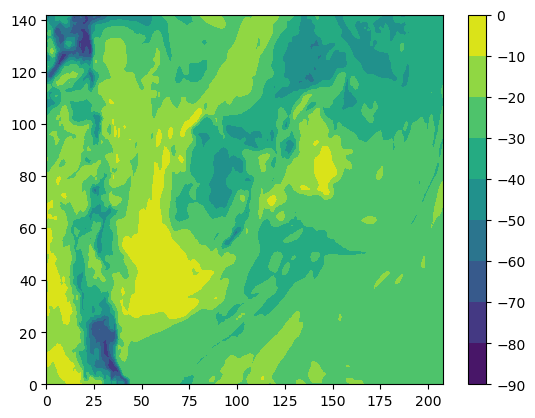

In [58]:
k=3

plt.contourf(rh3[k,:,:].squeeze()-rh0[k,:,:].squeeze())
plt.colorbar()
plt.show()